In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
plt.style.use('seaborn')
torch.manual_seed(2019)

In [6]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
vgg = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/canivel/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:29, 19310924.49it/s]


In [5]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [7]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [16]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])
    
    image = in_transform(image).unsqueeze(0)
    
    return image

In [21]:
content = load_image('./data/images/City.jpg').to(device)
style = load_image('./data/images/StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [22]:
#convert from tensor to numpy
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # (1,28,28)
    image = image.squeeze()
    image = image.transpose(1, 2, 0) # (28,28,1)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denormalize
    image = image.clip(0, 1)
    return image

(-0.5, 599.5, 399.5, -0.5)

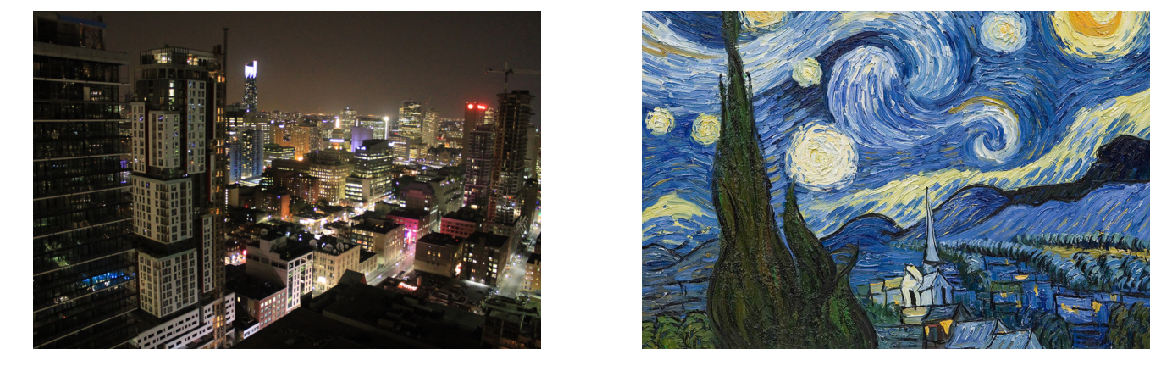

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [28]:
#extract features from the vgg19 model
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2', #content extraction
        '28': 'conv5_1'
    }
    
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [29]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [30]:
def gram_matrix(tensor):
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [31]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [32]:
style_weights = {'conv1_1': 1,
                'conv2_1': .75,
                'conv3_1': .2,
                'conv4_1': .2,
                'conv5_1': .2}

content_weight = 1
style_weight = 1e6

In [34]:
target = content.clone().requires_grad_(True).to(device)

In [36]:
show_every = 300
optmizer = torch.optim.Adam([target], lr=0.003)
steps=2100
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

In [38]:
for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss/(d * h * w)
        
    total_loss = (content_loss * content_weight) + (style_loss * style_weight)
    
    optmizer.zero_grad()
    total_loss.backward()
    optmizer.step()
    
    if ii % show_every == 0:
        print('Epoch: {} - Total loss: {}'.format(ii, total_loss))
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter += 1

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplot(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax2.imshow(im_convert(target))
ax2.axis('off')

# create the video of the transition

In [39]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.videoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i range(0, 300):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv.COLOR_BGR2RGB)
    vid.write(img)

vid.release()

ModuleNotFoundError: No module named 'cv2'